## Install and import packages

Run either the first cell (slower install) or second cell (faster by downloading directly from Google drive)

In [ ]:
# install libraries
# install.packages('forecast')
# install.packages('vars')
# install.packages('TSA')

In [ ]:
# faster library install
# create a folder called "library"
system("mkdir site-library")
# set the R default library path to the "library" folder we have created just now
.libPaths("site-library")
# download the pre-existing R environment file
# https://drive.google.com/file/d/14aPVP7hBCEFUdkaHXWqz_wI8h5VuLsqs/view?usp=share_link
R_environment_file <- "https://drive.usercontent.google.com/download?id=14aPVP7hBCEFUdkaHXWqz_wI8h5VuLsqs&export=download&authuser=0&confirm=t&uuid=609e8f24-8cf3-410d-ba9c-28639cb23f34&at=AN8xHooLEJIXoX2bOsSwRDXSfvD6:1754635911614"
download.file(R_environment_file, destfile="./library.tar.gz")
# unzip the compressed R library file: 'library.tar.gz' into the R library folder
untar("library.tar.gz", "site-library")

In [ ]:
# import libraries
library(forecast)
library(tseries)
library(vars)
library(TSA)
library(tidyverse)
library(fracdiff)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: MASS

Loading required package: strucchange

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich

Loading required package: urca

Loading required package: lmtest

Registered S3 methods overwritten by 'TSA':
  method       from    
  fitted.Arima forecast
  plot.Arima   forecast


Attaching package: ‘TSA’


The following objects are masked from ‘package:stats’:

    acf, arima


The following object is masked from ‘package:utils’:

    tar


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────

## Read data

In [ ]:
# import data from Google shared drive
# https://drive.google.com/file/d/1GxiUd8FyVAnqc80WCl3zDOGaf2gbeTGz/view?usp=share_link
file_id <- "1GxiUd8FyVAnqc80WCl3zDOGaf2gbeTGz"
file_path <- paste0("https://drive.google.com/uc?export=download&id=", file_id)
data <- read.csv(file_path)

In [ ]:
# preview data
head(data)

,Date,CPI,FedFunds,Unemployment,PPI,HousingIndex
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1990-01-01,127.4,8.23,5.4,107.5,76.527
2,1990-02-01,128.0,8.24,5.3,107.9,76.587
3,1990-03-01,128.7,8.28,5.2,108.5,76.790
4,1990-04-01,128.9,8.26,5.4,109.4,77.039
5,1990-05-01,129.2,8.18,5.4,110.1,77.297
6,1990-06-01,129.9,8.29,5.2,110.1,77.505


## Time series plot

In [ ]:
# convert to timeseries
ts_data <- ts(data[,-1], start=c(1990,1), frequency=12)
head(ts_data)

,CPI,FedFunds,Unemployment,PPI,HousingIndex
Jan 1990,127.4,8.23,5.4,107.5,76.527
Feb 1990,128.0,8.24,5.3,107.9,76.587
Mar 1990,128.7,8.28,5.2,108.5,76.790
Apr 1990,128.9,8.26,5.4,109.4,77.039
May 1990,129.2,8.18,5.4,110.1,77.297
Jun 1990,129.9,8.29,5.2,110.1,77.505


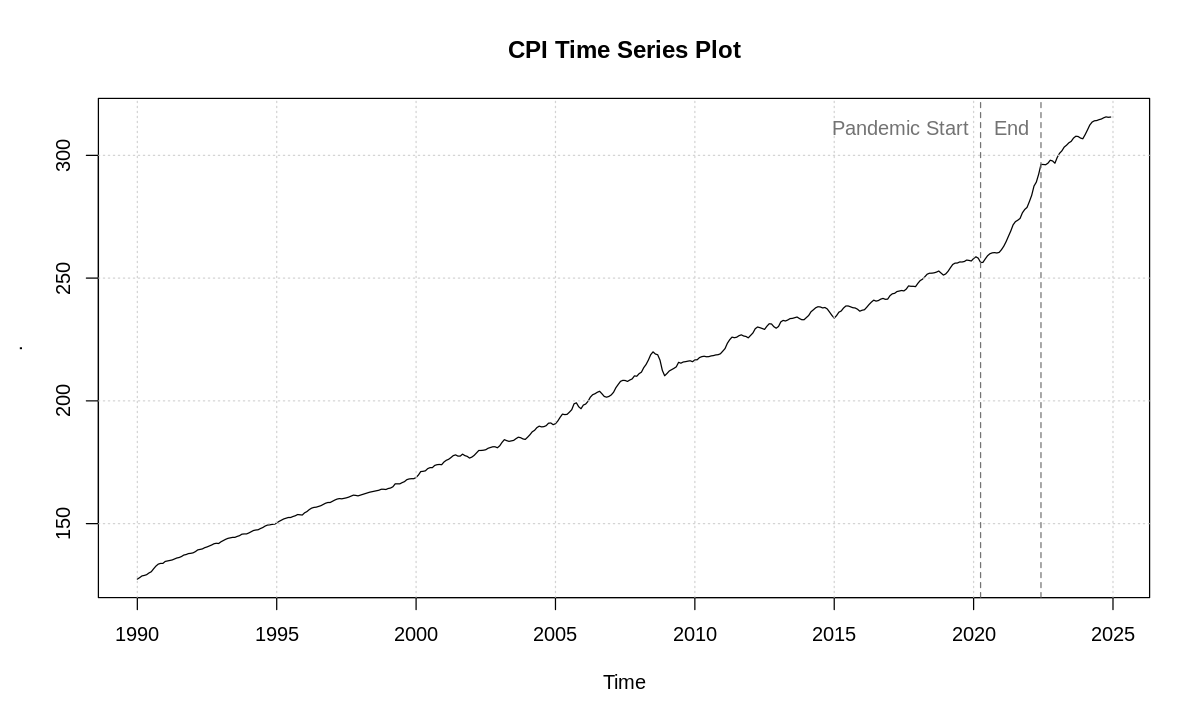

In [ ]:
# set R plots to better height and width
options(repr.plot.width=10, repr.plot.height=6)

# plot time series
ts_data[,"CPI"] %>% plot(main="CPI Time Series Plot")
grid(nx = NULL, ny = NULL, col = "lightgray", lty = "dotted")

abline(v=2020+3/12, col='#737373', lty=2)
text(x=2020+3/12, y=310, labels="Pandemic Start", col="#737373", pos=2)
abline(v=2022+5/12, col='#737373', lty=2)
text(x=2022+5/12, y=310, labels="End", col="#737373", pos=2)

## Intervention function specification

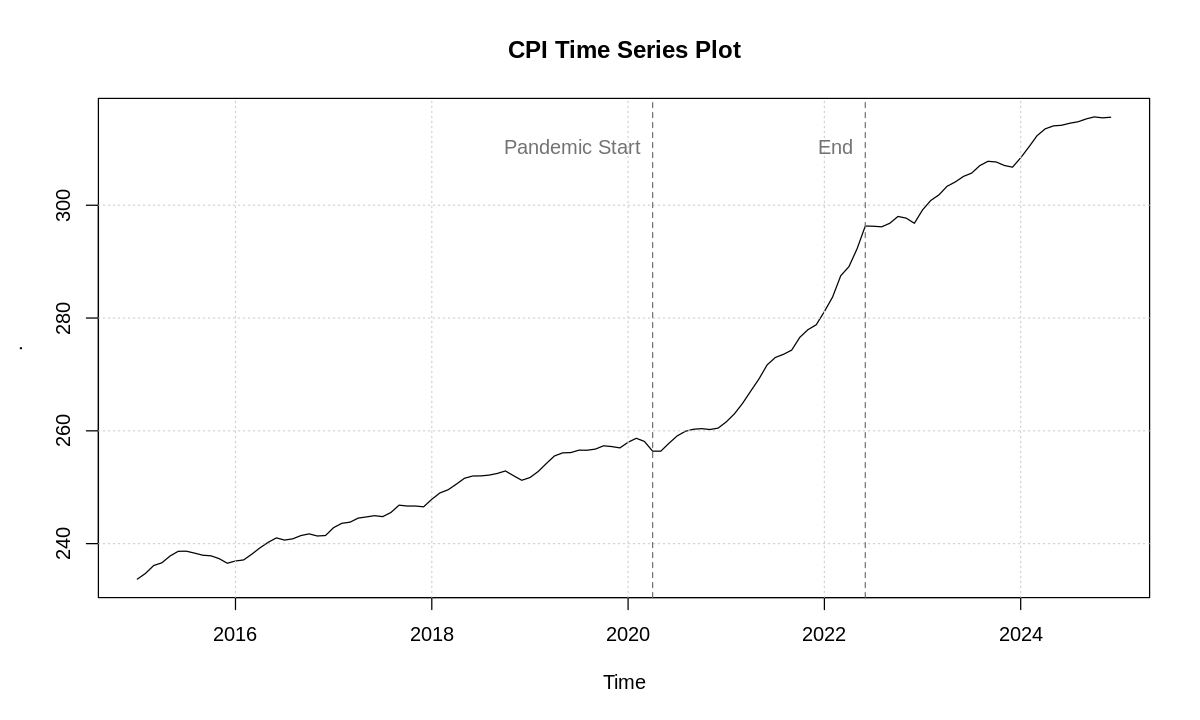

In [ ]:
# closer up
window(ts_data[,"CPI"], start=c(2015,1)) %>% plot(main="CPI Time Series Plot")
grid(nx = NULL, ny = NULL, col = "lightgray", lty = "dotted")

abline(v=2020+3/12, col='#737373', lty=2)
text(x=2020+3/12, y=310, labels="Pandemic Start", col="#737373", pos=2)
abline(v=2022+5/12, col='#737373', lty=2)
text(x=2022+5/12, y=310, labels="End", col="#737373", pos=2)

### Ramp function
Rationale: Evident from the plot above we observe both a step change and change in slope, first at the start of the pandemic and then again when we exit, the latter which arguably either persists or ends around 2024.

In [ ]:
# define the periods (n may need to adjusted for train/test split)
n <- length(ts_data[,"CPI"])
time <- 1:n
t1 <- (2020-1990)*12+3 # Mar 2020
t2 <- (2022-1990)*12+5 # May 2022

# create and bind the seperate intervention functions for entering / exiting pandemic
pandemic_periods <- cbind(
  period1 = c(rep(0, t1), 1:(t2-t1), rep((t2-t1), n-t2)),
  period2 = c(rep(0, t2), 1:(n-t2))
)

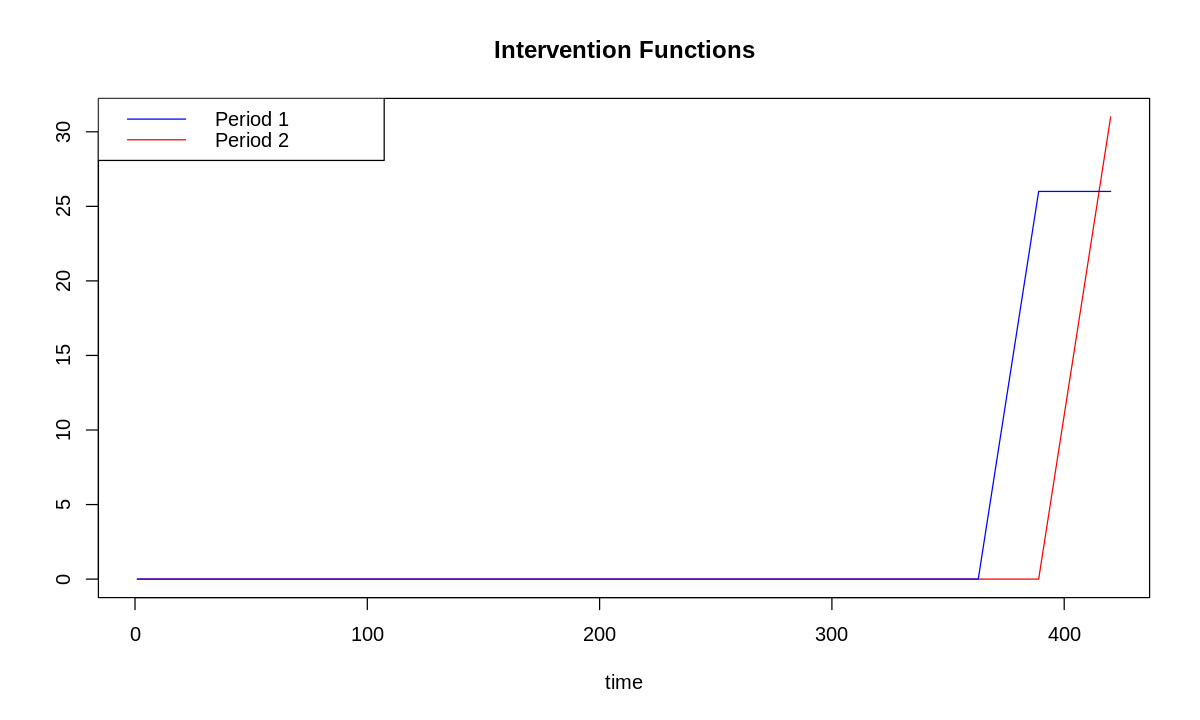

In [ ]:
# visual validation of intervention functions
plot(x=time, y=pandemic_periods[,"period2"], type="l", col="red", main="Intervention Functions", ylab="")
lines(x=time, y=pandemic_periods[,"period1"], type="l", col="blue")
legend("topleft", legend = c("Period 1", "Period 2"),  col = c("blue", "red"), lty=c(1,1))

## Fit Fourier for pre-intervention period
Additionally the time series needs to be stationary (or at least de-trended)

In [ ]:
# Select the pre-intervention period
fourier_window <- window(ts_data[,"CPI"], end=c(2020,2))

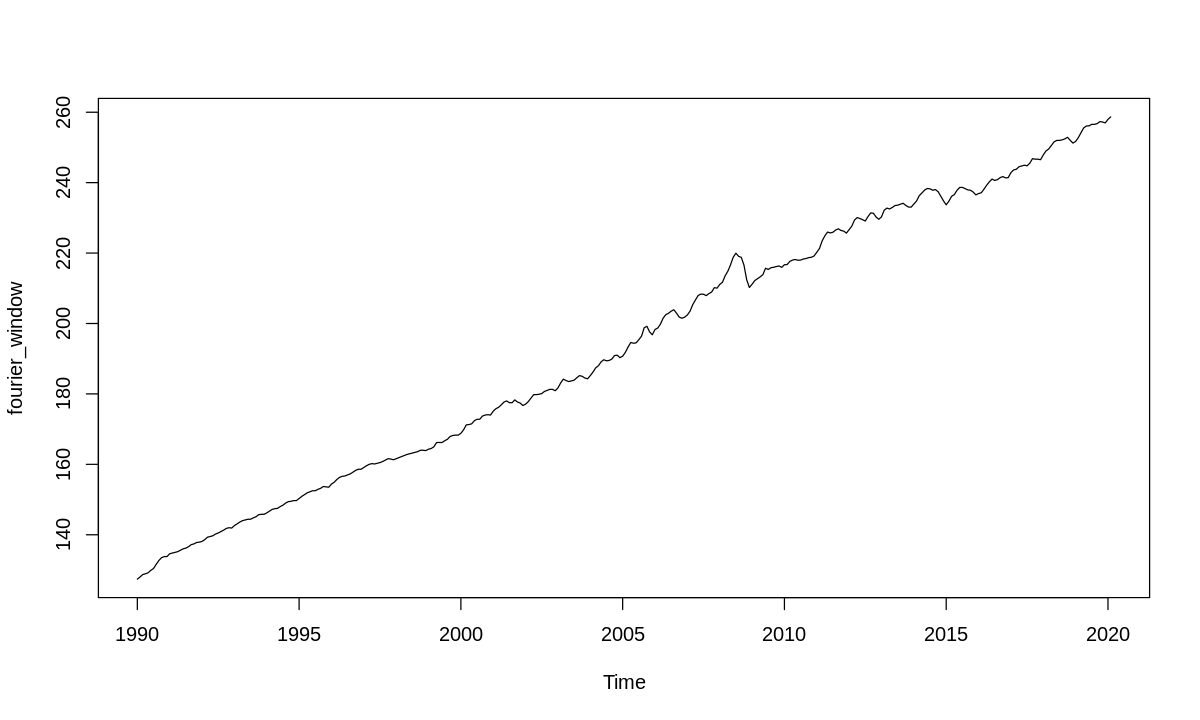

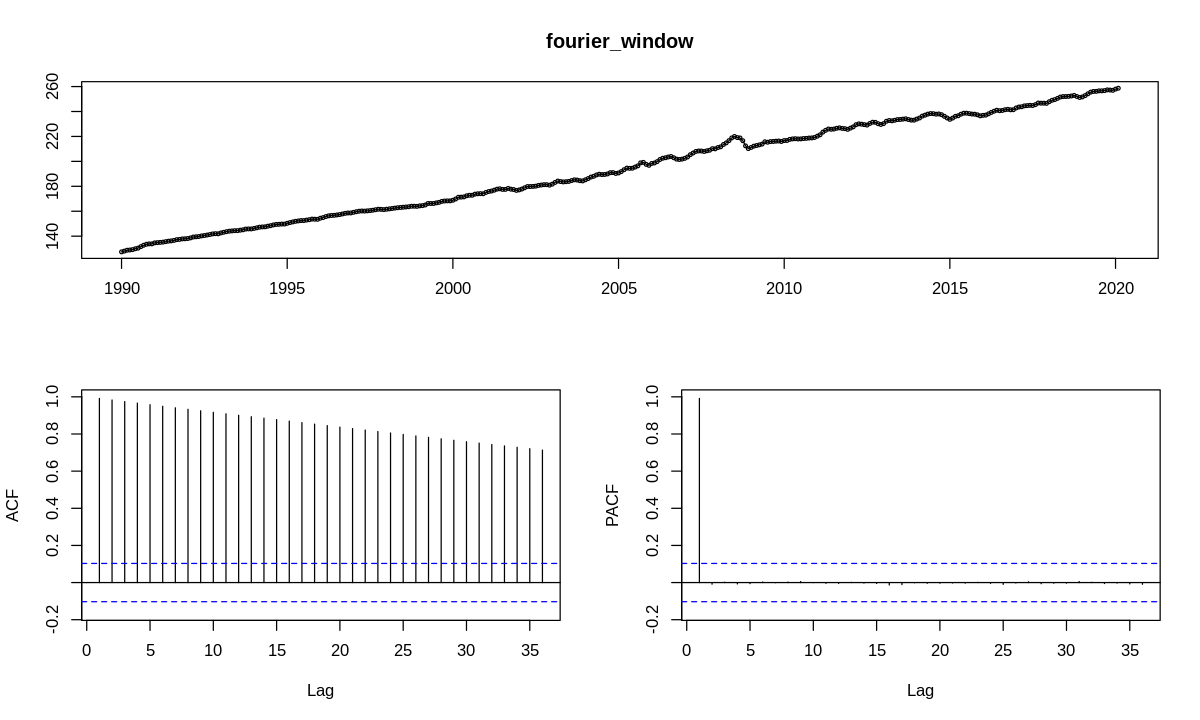

In [ ]:
# Conduct diagnostics
plot(fourier_window)
tsdisplay(fourier_window)

Moderate increase in variance with an upward trend over time suggests a Box-Cox transformation and/or differencing to stabilize. ADF p-value > 0.05 and KPSS p-value < 0.05 agree that the time series is not stationary.

In [ ]:
# Validate non-stationarity with hypothesis tests
fourier_window %>% adf.test()
fourier_window %>% kpss.test()


	Augmented Dickey-Fuller Test

data:  .
Dickey-Fuller = -2.2578, Lag order = 7, p-value = 0.4681
alternative hypothesis: stationary


Warning message in kpss.test(.):
“p-value smaller than printed p-value”



	KPSS Test for Level Stationarity

data:  .
KPSS Level = 6.155, Truncation lag parameter = 5, p-value = 0.01


### BoxCox

In [ ]:
## Get recommended lambda
BoxCox.lambda(fourier_window)

[1] 0.8691277

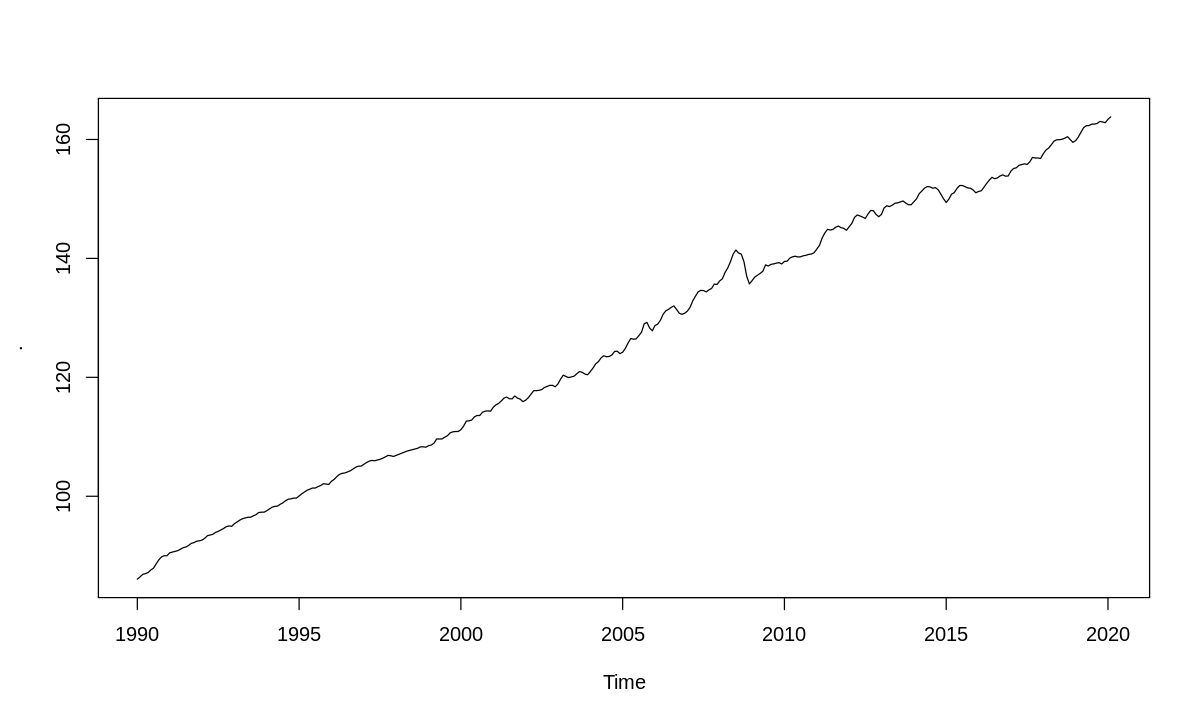

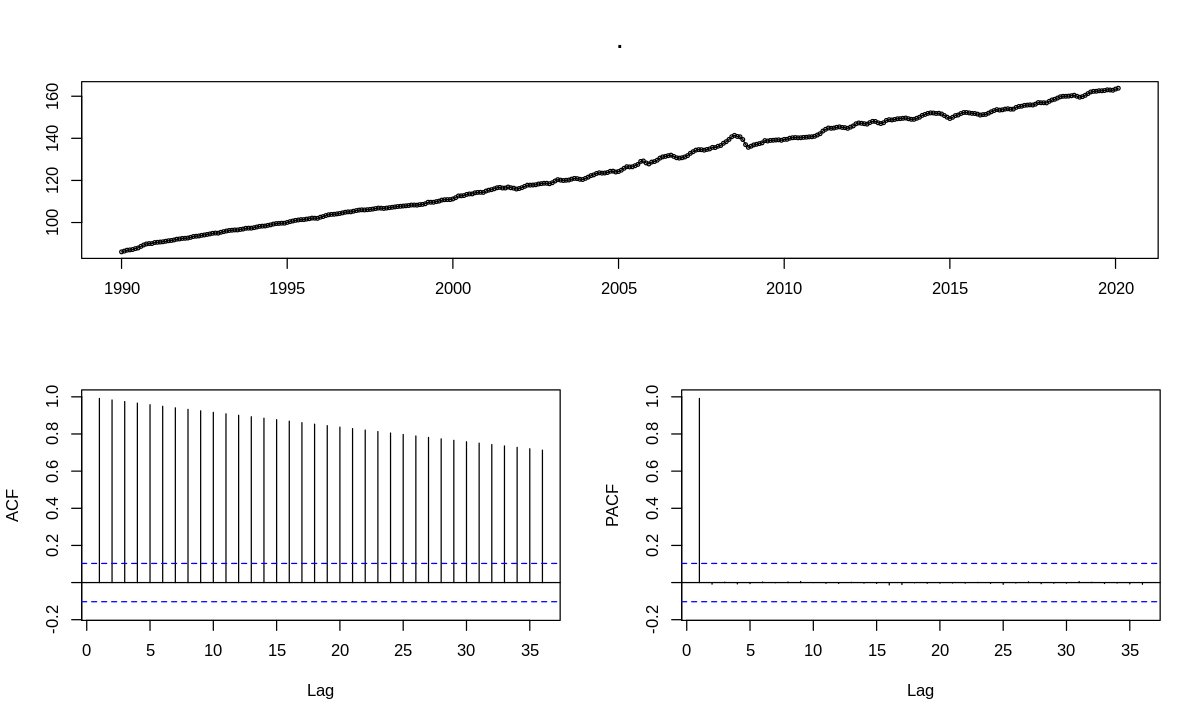

In [ ]:
## Plot after BoxCox only
fourier_window %>% BoxCox(0.9) %>% plot()
fourier_window %>% BoxCox(0.9) %>% tsdisplay()

In [ ]:
# Test after BoxCox transformed only
fourier_window %>% BoxCox(0.9) %>% adf.test()
fourier_window %>% BoxCox(0.9) %>% kpss.test()


	Augmented Dickey-Fuller Test

data:  .
Dickey-Fuller = -2.201, Lag order = 7, p-value = 0.4921
alternative hypothesis: stationary


Warning message in kpss.test(.):
“p-value smaller than printed p-value”



	KPSS Test for Level Stationarity

data:  .
KPSS Level = 6.1541, Truncation lag parameter = 5, p-value = 0.01


There is no material change to the time series variance instability or to the results for tests of stationarity with the BoxCox transformation

### Differencing d=1

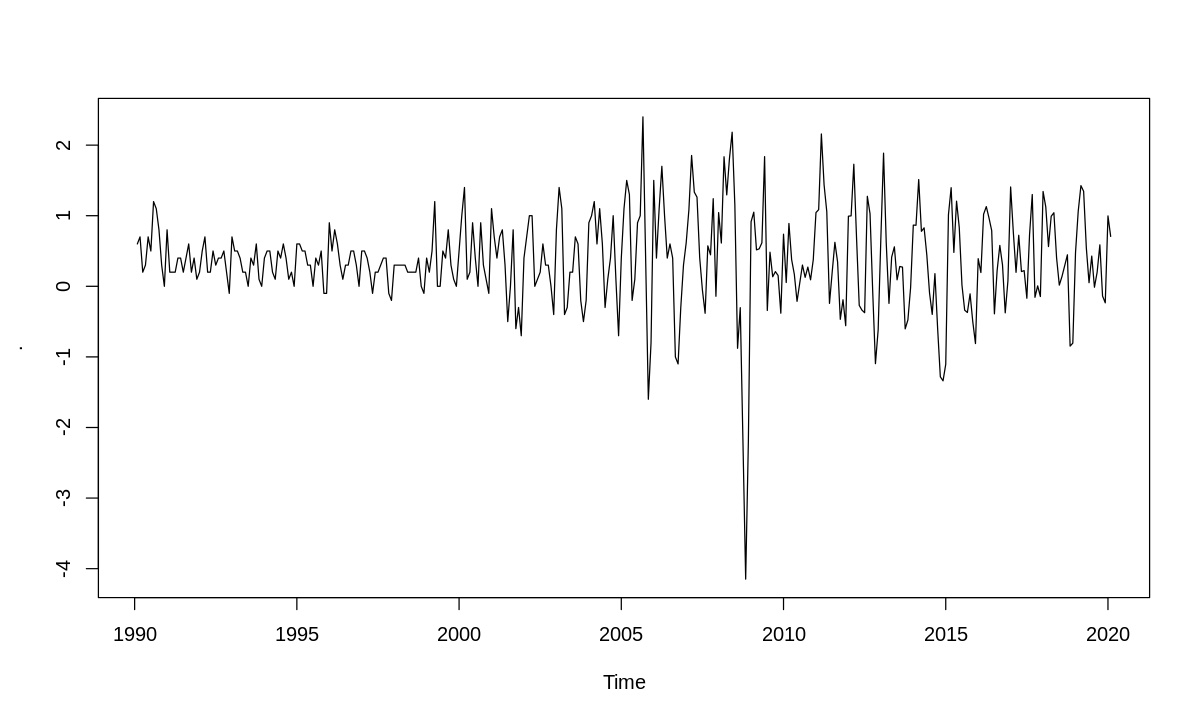

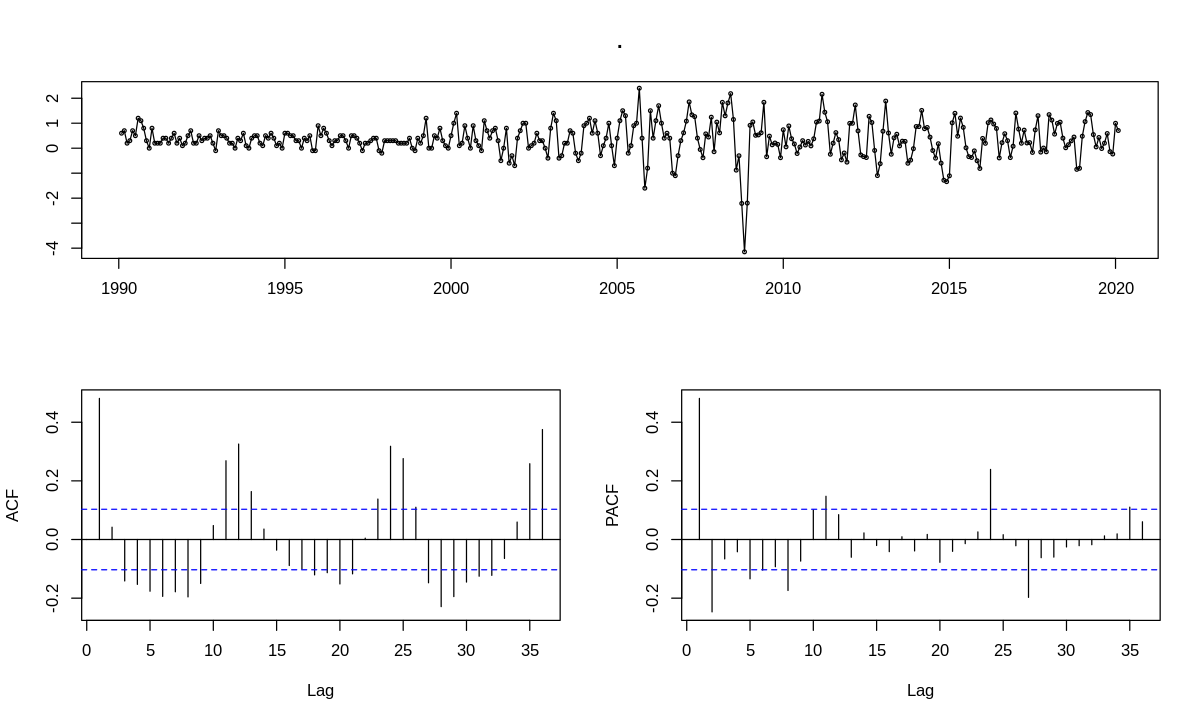

In [ ]:
## Plot after differencing only
fourier_window %>% diff(lag=1, differences=1) %>% plot()
fourier_window %>% diff(lag=1, differences=1) %>% tsdisplay()

In [ ]:
# Test after differencing only
fourier_window %>% diff(lag=1, differences=1) %>% adf.test()
fourier_window %>% diff(lag=1, differences=1) %>% kpss.test()

Warning message in adf.test(.):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  .
Dickey-Fuller = -10.105, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


Warning message in kpss.test(.):
“p-value greater than printed p-value”



	KPSS Test for Level Stationarity

data:  .
KPSS Level = 0.029078, Truncation lag parameter = 5, p-value = 0.1


ADF p-value < 0.05 and KPSS p-value > 0.05 agree that the time series is now stationary after non-seasonal differencing of order 1.

### Spectral analysis and periodogram

In [ ]:
# Keep differencing d = 1
fourier_window_diff <- diff(fourier_window, lag=1, differences=1)

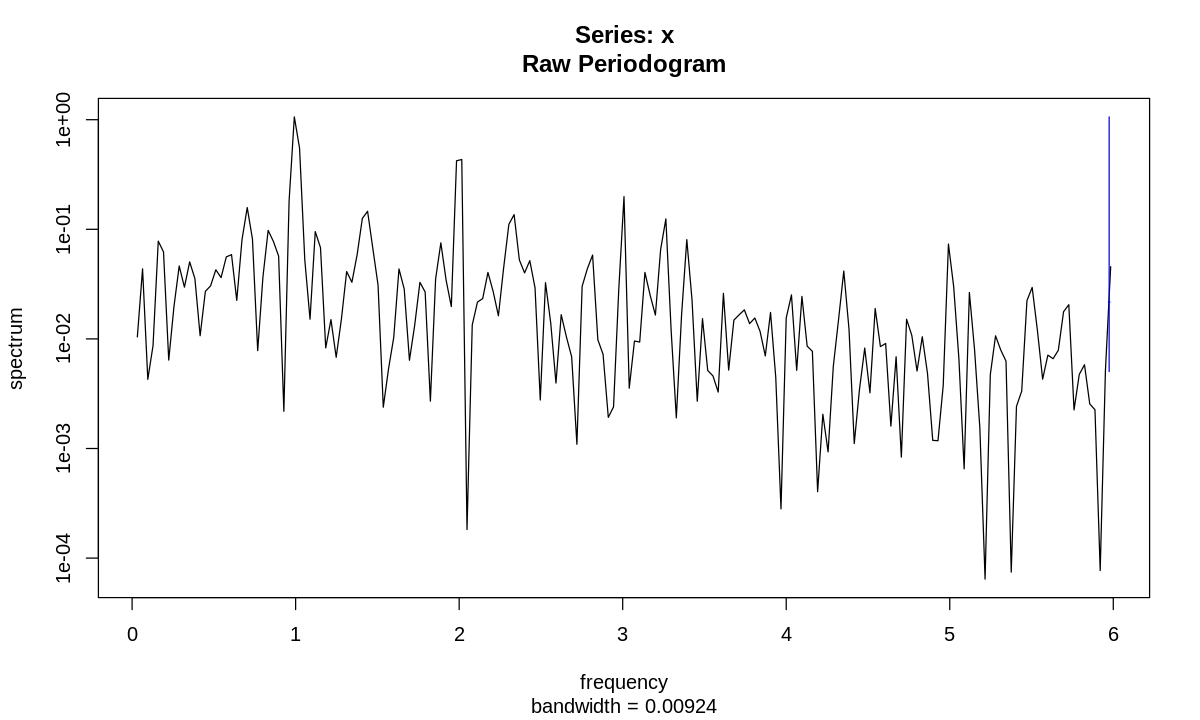

In [ ]:
# Spectrum
spectrum(fourier_window_diff)

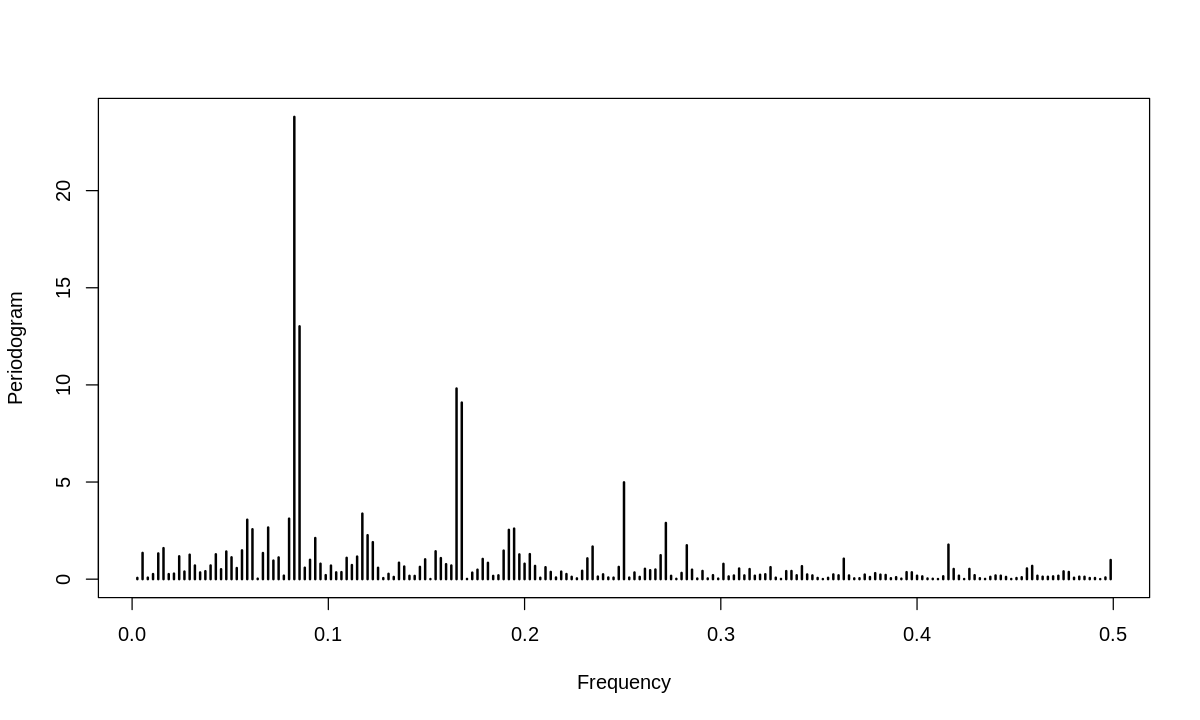

In [ ]:
# Periodogram
pgram <- periodogram(fourier_window_diff)

In [ ]:
# Extract the values
pgram_df <- data.frame(
  freq = pgram$freq, # Vector of frequencies at which the spectral density is estimated
  spec = pgram$spec # Vector of estimates of the periodogram at frequencies corresponding to freq
)

# Calculate the period
pgram_df$period <- 1/pgram_df$freq

# Find the frequency with highest spectral density
dplyr::arrange(pgram_df, desc(spec)) %>% head()

,freq,spec,period
,<dbl>,<dbl>,<dbl>
1,0.08266667,23.797697,12.096774
2,0.08533333,13.015241,11.718750
3,0.16533333,9.813474,6.048387
4,0.16800000,9.089882,5.952381
5,0.25066667,4.983722,3.989362
6,0.11733333,3.373127,8.522727


This suggests the possibility of 2 significant frequency pairs (seasonal components) at periods of 12 (annual) and 6 (bi-annual) respectively, in order of importance. However, we will need to specify to `fourier()` K of either 3 or 4 to extract these pairs since the first two dominant frequency pairs are both for period 12.

### Specify the fourier terms

In [ ]:
# Fourier decomposition
fourier_decomp <- fourier(fourier_window, K=4)

In [ ]:
# Capture results in dataframe
f_df <- data.frame(fourier_decomp)
f_df$time <- 1:nrow(f_df)
head(f_df)

,S1.12,C1.12,S2.12,C2.12,S3.12,C3.12,S4.12,C4.12,time
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.5000000,0.8660254,0.8660254,0.5,1,0,0.8660254,-0.5,1
2,0.8660254,0.5000000,0.8660254,-0.5,0,-1,-0.8660254,-0.5,2
3,1.0000000,0.0000000,0.0000000,-1.0,-1,0,0.0000000,1.0,3
4,0.8660254,-0.5000000,-0.8660254,-0.5,0,1,0.8660254,-0.5,4
5,0.5000000,-0.8660254,-0.8660254,0.5,1,0,-0.8660254,-0.5,5
6,0.0000000,-1.0000000,0.0000000,1.0,0,-1,0.0000000,1.0,6


In [ ]:
# Pivot longer after filtering only first few cycles
f_df_long <- f_df %>% head(12*2) %>% pivot_longer(cols=colnames(f_df[,-9]), names_to = "variable", values_to = "value")

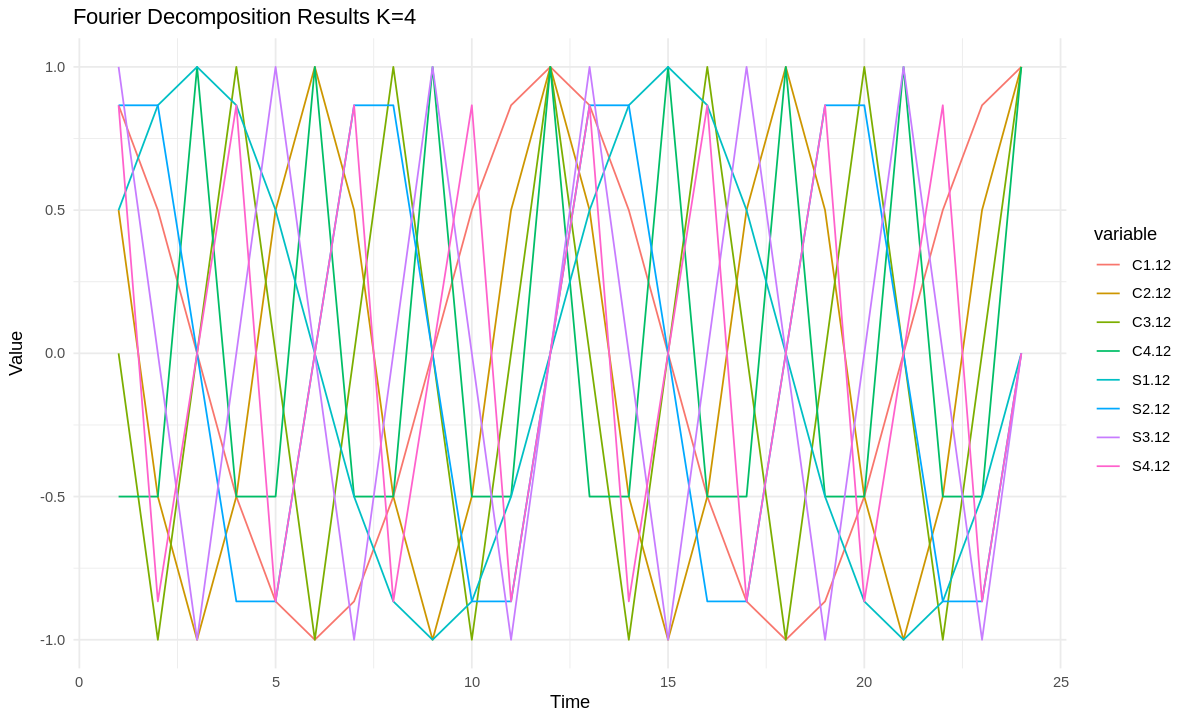

In [ ]:
# View the seasonal components captured
ggplot(f_df_long, aes(x=time, y=value, color=variable)) +
  geom_line() +
  labs(title = "Fourier Decomposition Results K=4",
       x = "Time",
       y = "Value"
      ) +
  theme_minimal()

## Train test split

In [ ]:
# Train test split with h = 12 for validation period
ts_train <- window(ts_data, end=c(2023,12))
ts_test <- window(ts_data, start=c(2024,1))

## Incremental Model Spec & Validation

### Step 1: Intervention Specification
Validate determistic components specification via AICc for various intervention functions

**Takeaway:** Intervention with step function has lowest AICc of 760 and improves on baseline of 783

In [ ]:
# define the intervention
n <- nrow(ts_train)
time <- 1:n
t1 <- (2020-1990)*12+3 # Mar 2020
t2 <- (2022-1990)*12+5 # May 2022

# option 1) step function
step_intervention <-
  c(rep(0, t1), rep(1, t2-t1), rep(0, n-t2))
  #c(rep(0, t1), rep(1, n-t1))

# option 2) ramp function
ramp_intervention <-
  c(rep(0, t1), 1:(t2-t1), rep((t2-t1), n-t2))

# option 3) ramp function x2
ramptwo_intervention <- cbind(
  period1 = c(rep(0, t1), 1:(t2-t1), rep((t2-t1), n-t2)),
  period2 = c(rep(0, t2), 1:(n-t2))
)

# option 4) step function x2
steptwo_intervention <- cbind(
  period1 = c(rep(0, t1), rep(1, t2-t1), rep(0, n-t2)),
  period2 = c(rep(0, t2), rep(1, n-t2))
)

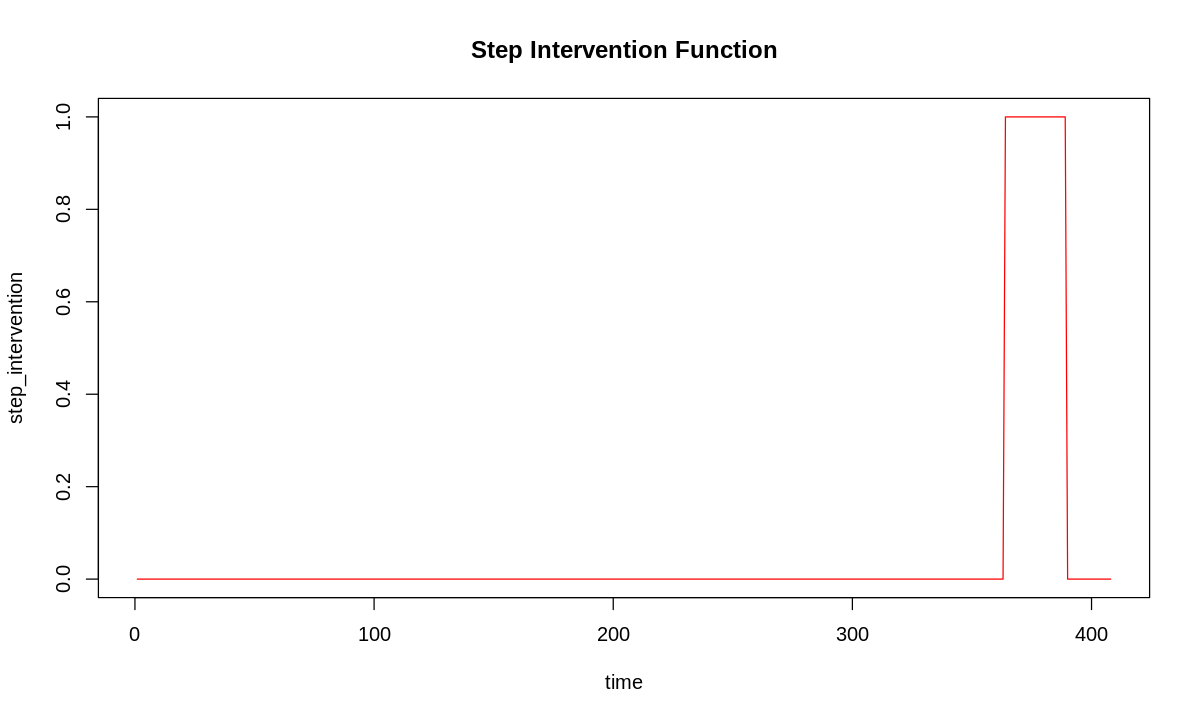

In [ ]:
# visual validation of step intervention
plot(x=time, y=step_intervention, type="l", col="red", main="Step Intervention Function")

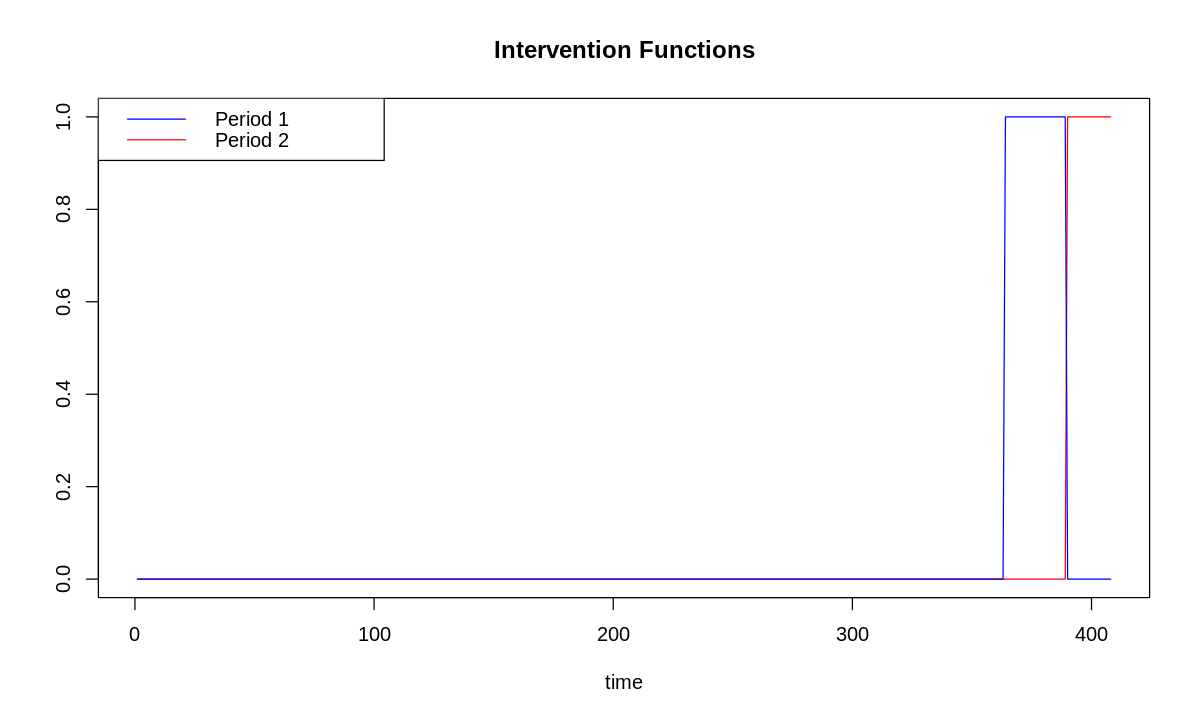

In [ ]:
# visual validation of two step intervention
plot(x=time, y=steptwo_intervention[,"period2"], type="l", col="red", main="Intervention Functions", ylab="")
lines(x=time, y=steptwo_intervention[,"period1"], type="l", col="blue")
legend("topleft", legend = c("Period 1", "Period 2"),  col = c("blue", "red"), lty=c(1,1))

#### Baseline: ARIMA No Intervention

In [ ]:
auto.arima(ts_train[,"CPI"], seasonal=TRUE) %>% summary()

Series: ts_train[, "CPI"] 
ARIMA(0,2,3)(0,0,2)[12] 

Coefficients:
          ma1      ma2      ma3    sma1    sma2
      -0.3859  -0.4551  -0.1355  0.1805  0.1338
s.e.   0.0498   0.0500   0.0532  0.0534  0.0483

sigma^2 = 0.3929:  log likelihood = -385.49
AIC=782.99   AICc=783.2   BIC=807.03

Training set error measures:
                     ME      RMSE       MAE         MPE      MAPE       MASE
Training set 0.01717916 0.6214364 0.4375386 0.003690955 0.2069341 0.08136579
                     ACF1
Training set -0.001590032

#### ARIMA with Step Intervention only

In [ ]:
auto.arima(ts_train[,"CPI"], xreg=step_intervention, seasonal=TRUE) %>% summary()

Series: ts_train[, "CPI"] 
Regression with ARIMA(0,1,2)(0,0,2)[12] errors 

Coefficients:
         ma1     ma2    sma1    sma2   drift     xreg
      0.5835  0.1744  0.2042  0.0947  0.4448  -1.7672
s.e.  0.0510  0.0518  0.0541  0.0489  0.0677   0.3819

sigma^2 = 0.371:  log likelihood = -373.19
AIC=760.38   AICc=760.66   BIC=788.44

Training set error measures:
                        ME      RMSE       MAE          MPE      MAPE
Training set -0.0004169637 0.6038708 0.4273859 -0.005326143 0.2035961
                   MASE         ACF1
Training set 0.07947777 0.0004982923

#### ARIMA with Ramp Intervention only

In [ ]:
auto.arima(ts_train[,"CPI"], xreg=ramp_intervention, seasonal=TRUE) %>% summary()

Series: ts_train[, "CPI"] 
Regression with ARIMA(2,2,0)(0,0,2)[12] errors 

Coefficients:
          ar1      ar2    sma1    sma2     xreg
      -0.1515  -0.3278  0.1444  0.1714  -0.0312
s.e.   0.0475   0.0477  0.0543  0.0494   0.4524

sigma^2 = 0.4738:  log likelihood = -422.5
AIC=856.99   AICc=857.2   BIC=881.03

Training set error measures:
                       ME      RMSE       MAE           MPE      MAPE
Training set -0.003420167 0.6824366 0.4898567 -0.0009379932 0.2329879
                   MASE        ACF1
Training set 0.09109501 -0.06226368

#### ARIMA with Ramp (Two Periods)

In [ ]:
auto.arima(ts_train[,"CPI"], xreg=ramptwo_intervention, seasonal=TRUE) %>% summary()

Series: ts_train[, "CPI"] 
Regression with ARIMA(2,2,0)(0,0,2)[12] errors 

Coefficients:
          ar1      ar2    sma1    sma2  period1  period2
      -0.1623  -0.3342  0.1488  0.1734  -0.6288  -1.2526
s.e.   0.0480   0.0477  0.0542  0.0495   0.6307   0.9241

sigma^2 = 0.4729:  log likelihood = -421.59
AIC=857.17   AICc=857.45   BIC=885.22

Training set error measures:
                       ME     RMSE       MAE          MPE      MAPE       MASE
Training set 0.0002298862 0.680878 0.4894316 0.0003967357 0.2327195 0.09101594
                    ACF1
Training set -0.06222037

#### ARIMA with Step Intervention only (Two Periods)

In [ ]:
auto.arima(ts_train[,"CPI"], xreg=steptwo_intervention, seasonal=TRUE) %>% summary()

Series: ts_train[, "CPI"] 
Regression with ARIMA(0,1,2)(0,0,2)[12] errors 

Coefficients:
         ma1     ma2    sma1    sma2   drift  period1  period2
      0.5901  0.1858  0.1913  0.1004  0.4427  -1.3235   0.8805
s.e.  0.0513  0.0526  0.0555  0.0493  0.0680   0.5318   0.7432

sigma^2 = 0.3707:  log likelihood = -372.49
AIC=760.98   AICc=761.34   BIC=793.05

Training set error measures:
                        ME      RMSE       MAE          MPE     MAPE       MASE
Training set -0.0003996526 0.6028479 0.4274058 -0.005153824 0.203562 0.07948146
                      ACF1
Training set -0.0009251151

### Step 2: Harmonic Specification
Ignoring the intervention period here and for completeness we will try various K values.

**Takeaway:** Harmonics with K=3 has the lowest AICc of 730

In [ ]:
# define the harmonics (ignore intervention)
harmonics_4 <- ts_train %>% fourier(K=4)
harmonics_3 <- ts_train %>% fourier(K=3)
harmonics_2 <- ts_train %>% fourier(K=2)

#### ARIMA with Harmonic K=4

In [ ]:
auto.arima(ts_train[,"CPI"], xreg=harmonics_4, seasonal=FALSE) %>% summary()

Series: ts_train[, "CPI"] 
Regression with ARIMA(1,1,2) errors 

Coefficients:
         ar1      ma1      ma2   drift    S1-12    C1-12    S2-12    C2-12
      0.9171  -0.4127  -0.3453  0.4418  -0.1911  -0.7615  -0.1435  -0.2512
s.e.  0.0648   0.0882   0.0686  0.0822   0.1070   0.1071   0.0490   0.0490
        S3-12    C3-12   S4-12    C4-12
      -0.0022  -0.1487  0.0289  -0.0044
s.e.   0.0296   0.0296  0.0193   0.0194

sigma^2 = 0.3413:  log likelihood = -352.8
AIC=731.6   AICc=732.53   BIC=783.72

Training set error measures:
                      ME      RMSE       MAE          MPE      MAPE       MASE
Training set 0.001408513 0.5747923 0.4170837 -0.003542091 0.2012739 0.07756195
                  ACF1
Training set 0.0211404

#### ARIMA with Harmonic K=3

In [ ]:
auto.arima(ts_train[,"CPI"], xreg=harmonics_3, seasonal=FALSE) %>% summary()

Series: ts_train[, "CPI"] 
Regression with ARIMA(1,1,2) errors 

Coefficients:
         ar1      ma1      ma2   drift    S1-12    C1-12    S2-12    C2-12
      0.9190  -0.4156  -0.3473  0.4419  -0.1915  -0.7617  -0.1438  -0.2512
s.e.  0.0626   0.0858   0.0673  0.0825   0.1072   0.1073   0.0492   0.0492
        S3-12    C3-12
      -0.0022  -0.1487
s.e.   0.0297   0.0297

sigma^2 = 0.3414:  log likelihood = -353.94
AIC=729.87   AICc=730.54   BIC=773.97

Training set error measures:
                      ME      RMSE      MAE          MPE     MAPE       MASE
Training set 0.001492859 0.5763969 0.413767 -0.003504033 0.199434 0.07694517
                   ACF1
Training set 0.01926144

#### ARIMA with Harmonic K=2

In [ ]:
auto.arima(ts_train[,"CPI"], xreg=harmonics_2, seasonal=FALSE) %>% summary()

Series: ts_train[, "CPI"] 
Regression with ARIMA(1,1,2) errors 

Coefficients:
         ar1      ma1      ma2   drift    S1-12    C1-12    S2-12    C2-12
      0.9350  -0.4227  -0.3854  0.4439  -0.1923  -0.7614  -0.1441  -0.2509
s.e.  0.0484   0.0711   0.0577  0.0856   0.1118   0.1118   0.0518   0.0518

sigma^2 = 0.3602:  log likelihood = -365.87
AIC=749.74   AICc=750.2   BIC=785.82

Training set error measures:
                     ME      RMSE       MAE          MPE      MAPE       MASE
Training set 0.00113919 0.5935376 0.4254745 -0.003790086 0.2043648 0.07912233
                    ACF1
Training set 0.009187275

#### ARIMA with Harmonic K=2, 3, 4 (Exclude Intervention)
Excluding intervention, K=3 remains the best fit for seasonal component with lowest AICc at 542.

In [ ]:
# define the harmonics (exclude intervention period)
ts_train_pre <- window(ts_train, end=c(2020, 2))
harmonics_4_pre <- ts_train_pre %>% fourier(K=4)
harmonics_3_pre <- ts_train_pre %>% fourier(K=3)
harmonics_2_pre <- ts_train_pre %>% fourier(K=2)

In [ ]:
auto.arima(ts_train_pre[,"CPI"], xreg=harmonics_4_pre, seasonal=FALSE) %>% summary()
auto.arima(ts_train_pre[,"CPI"], xreg=harmonics_3_pre, seasonal=FALSE) %>% summary()
auto.arima(ts_train_pre[,"CPI"], xreg=harmonics_2_pre, seasonal=FALSE) %>% summary()

Series: ts_train_pre[, "CPI"] 
Regression with ARIMA(2,1,1) errors 

Coefficients:
         ar1      ar2      ma1   drift    S1-12    C1-12    S2-12    C2-12
      1.2520  -0.4304  -0.8202  0.3608  -0.1518  -0.7108  -0.1748  -0.2628
s.e.  0.0975   0.0502   0.0975  0.0265   0.1249   0.1249   0.0467   0.0466
       S3-12    C3-12   S4-12    C4-12
      0.0182  -0.1181  0.0279  -0.0073
s.e.  0.0245   0.0245  0.0166   0.0166

sigma^2 = 0.2534:  log likelihood = -258.48
AIC=542.96   AICc=544.01   BIC=593.52

Training set error measures:
                       ME     RMSE       MAE         MPE      MAPE       MASE
Training set 0.0008275269 0.494286 0.3630465 0.000569152 0.1851842 0.08181503
                    ACF1
Training set 0.007913236

Series: ts_train_pre[, "CPI"] 
Regression with ARIMA(2,1,1) errors 

Coefficients:
         ar1      ar2      ma1   drift    S1-12    C1-12    S2-12    C2-12
      1.2507  -0.4274  -0.8230  0.3606  -0.1527  -0.7099  -0.1749  -0.2625
s.e.  0.0975   0.0502   0.0973  0.0264   0.1247   0.1247   0.0468   0.0467
       S3-12    C3-12
      0.0182  -0.1180
s.e.  0.0246   0.0246

sigma^2 = 0.2541:  log likelihood = -259.98
AIC=541.97   AICc=542.72   BIC=584.74

Training set error measures:
                       ME      RMSE       MAE          MPE     MAPE       MASE
Training set 0.0008506724 0.4963511 0.3621762 0.0005723253 0.184568 0.08161891
                    ACF1
Training set 0.007802037

Series: ts_train_pre[, "CPI"] 
Regression with ARIMA(0,1,2) errors 

Coefficients:
         ma1     ma2   drift    S1-12    C1-12    S2-12    C2-12
      0.4581  0.0792  0.3616  -0.1510  -0.7125  -0.1742  -0.2624
s.e.  0.0543  0.0541  0.0416   0.1085   0.1085   0.0490   0.0488

sigma^2 = 0.2704:  log likelihood = -272.7
AIC=561.41   AICc=561.82   BIC=592.52

Training set error measures:
                       ME      RMSE       MAE          MPE      MAPE       MASE
Training set 0.0005545435 0.5142134 0.3753113 0.0003670257 0.1914291 0.08457898
                    ACF1
Training set -0.00382056

### Step 3: With exogenous variables

Housing Index, FedFunds, and Unmployment all move AICc down to around 770 (758 for Housing Index). PPI only has marginal impact.

However when all variables are supplied the AICc increases to over 1300.

Finally, excluding PPI results in the best AICc of 730.

In [ ]:
# define the covariates FedFunds	Unemployment	PPI	HousingIndex
fed <- ts_train[,"FedFunds"]
unemployment <- ts_train[,"Unemployment"]
ppi <- ts_train[,"PPI"]
housing <- ts_train[,"HousingIndex"]

#### ARIMA with Fedfunds

In [ ]:
auto.arima(ts_train[,"CPI"], xreg=fed, seasonal=TRUE) %>% summary()

Series: ts_train[, "CPI"] 
Regression with ARIMA(0,2,2)(0,0,2)[12] errors 

Coefficients:
          ma1      ma2    sma1    sma2    xreg
      -0.4483  -0.5276  0.1902  0.1336  0.7315
s.e.   0.0408   0.0410  0.0532  0.0468  0.1974

sigma^2 = 0.3862:  log likelihood = -382.03
AIC=776.05   AICc=776.26   BIC=800.09

Training set error measures:
                     ME     RMSE       MAE          MPE      MAPE       MASE
Training set 0.01060634 0.616062 0.4334066 0.0002571508 0.2052676 0.08059739
                   ACF1
Training set 0.05334435

#### ARIMA with Unemployment

In [ ]:
auto.arima(ts_train[,"CPI"], xreg=unemployment, seasonal=TRUE) %>% summary()

Series: ts_train[, "CPI"] 
Regression with ARIMA(0,1,2)(0,0,2)[12] errors 

Coefficients:
         ma1     ma2    sma1    sma2   drift     xreg
      0.5847  0.1370  0.2148  0.1082  0.4449  -0.1276
s.e.  0.0507  0.0521  0.0541  0.0494  0.0688   0.0488

sigma^2 = 0.385:  log likelihood = -380.77
AIC=775.55   AICc=775.83   BIC=803.61

Training set error measures:
                        ME      RMSE       MAE          MPE      MAPE
Training set -0.0004908218 0.6151505 0.4334579 -0.005468157 0.2056646
                   MASE        ACF1
Training set 0.08060694 0.002986134

#### ARIMA with PPI

In [ ]:
auto.arima(ts_train[,"CPI"], xreg=ppi, seasonal=TRUE) %>% summary()

Series: ts_train[, "CPI"] 
Regression with ARIMA(0,1,2)(0,0,2)[12] errors 

Coefficients:
         ma1     ma2    sma1    sma2   drift    xreg
      0.6062  0.1450  0.1768  0.1365  0.4438  0.0055
s.e.  0.0495  0.0525  0.0725  0.0483  0.0707  0.0285

sigma^2 = 0.3916:  log likelihood = -384.23
AIC=782.45   AICc=782.73   BIC=810.51

Training set error measures:
                        ME      RMSE       MAE          MPE      MAPE
Training set -0.0003435838 0.6203665 0.4366032 -0.005392422 0.2065929
                   MASE        ACF1
Training set 0.08119185 0.002549554

#### ARIMA with Housing Index

In [ ]:
auto.arima(ts_train[,"CPI"], xreg=housing, seasonal=TRUE) %>% summary()

Series: ts_train[, "CPI"] 
Regression with ARIMA(2,2,1)(0,0,1)[12] errors 

Coefficients:
         ar1      ar2      ma1    sma1    xreg
      0.5059  -0.2282  -0.9725  0.1626  0.2308
s.e.  0.0524   0.0531   0.0290  0.0481  0.0381

sigma^2 = 0.3701:  log likelihood = -373.12
AIC=758.24   AICc=758.45   BIC=782.27

Training set error measures:
                        ME      RMSE      MAE          MPE      MAPE       MASE
Training set -0.0001868695 0.6031532 0.430022 -0.004636995 0.2045696 0.07996798
                   ACF1
Training set 0.00942631

#### ARIMA all exogenous

In [ ]:
auto.arima(ts_train[,"CPI"], xreg=cbind(fed, unemployment, ppi, housing),
  seasonal=TRUE) %>% summary()

Series: ts_train[, "CPI"] 
Regression with ARIMA(0,0,5)(0,0,2)[12] errors 

Coefficients:
         ma1     ma2     ma3     ma4     ma5    sma1    sma2  intercept
      1.9217  2.2621  2.0895  1.4107  0.4036  0.6729  0.4003    91.5687
s.e.  0.0543  0.0892  0.1067  0.0897  0.0509  0.0823  0.0531     4.1806
          fed  unemployment     ppi  housing
      -0.8516       -0.0252  0.1487   0.6074
s.e.   0.2973        0.0635  0.0421   0.0270

sigma^2 = 1.351:  log likelihood = -640.29
AIC=1306.59   AICc=1307.51   BIC=1358.73

Training set error measures:
                     ME    RMSE       MAE         MPE      MAPE      MASE
Training set 0.04119138 1.14529 0.8754892 -0.01051423 0.4272274 0.1628082
                  ACF1
Training set 0.1112521

#### ARIMA all exog excluding PPI

In [ ]:
auto.arima(ts_train[,"CPI"], xreg=cbind(fed, unemployment, housing),
  seasonal=TRUE) %>% summary()

Series: ts_train[, "CPI"] 
Regression with ARIMA(0,1,1)(0,0,2)[12] errors 

Coefficients:
         ma1    sma1    sma2   drift     fed  unemployment  housing
      0.4972  0.1809  0.1081  0.3249  0.6392       -0.1165   0.2168
s.e.  0.0418  0.0540  0.0489  0.0587  0.1870        0.0474   0.0341

sigma^2 = 0.3463:  log likelihood = -358.62
AIC=733.24   AICc=733.6   BIC=765.31

Training set error measures:
                       ME     RMSE      MAE          MPE      MAPE     MASE
Training set -0.001654042 0.582697 0.420133 -0.001476719 0.2005085 0.078129
                   ACF1
Training set 0.02084243

### Step 4: Combine best specifications from 1-3

**Note on harmonic specification:** In practice it may be best to specify the harmonic frequency cleanly before the intervention period. For simplicity and avoiding having to forecast the harminonic frequency within the training period, we specify it using the entire training period (including the intervention period). We presume enough historic data spanning back to 1990 will likely drown out the noise from the intervention period.

High level structre of this final model:
- Deterministic: Fourier frequencies + intervention function + covariates
- Stochastic: Arima

In [ ]:
# define again final specs on training data for clarity
step_intervention <- c(rep(0, t1), rep(1, t2-t1), rep(0, n-t2))
harmonics_3 <- ts_train[,"CPI"] %>% fourier(K=3)
fed <- ts_train[,"FedFunds"]
unemployment <- ts_train[,"Unemployment"]
#ppi <- ts_train[,"PPI"]
housing <- ts_train[,"HousingIndex"]

In [ ]:
# combine to final matrix to feed into xreg
all_xreg <- cbind(step_intervention, harmonics_3, fed, unemployment, housing)

In [ ]:
best_harmonic <- auto.arima(ts_train[,"CPI"], xreg=all_xreg, seasonal=FALSE)
best_harmonic %>% summary()

Series: ts_train[, "CPI"] 
Regression with ARIMA(0,1,2) errors 

Coefficients:
         ma1     ma2   drift  step_intervention  harmonics_3.S1-12
      0.4495  0.0953  0.3260            -2.3840             0.0863
s.e.  0.0505  0.0490  0.0443             0.4637             0.1110
      harmonics_3.C1-12  harmonics_3.S2-12  harmonics_3.C2-12
                -0.5001            -0.1405            -0.2821
s.e.             0.1122             0.0472             0.0472
      harmonics_3.S3-12  harmonics_3.C3-12     fed  unemployment  housing
                 0.0107            -0.1475  0.5405        0.0730   0.2068
s.e.             0.0265             0.0265  0.1746        0.0569   0.0318

sigma^2 = 0.2874:  log likelihood = -317.26
AIC=662.53   AICc=663.6   BIC=718.65

Training set error measures:
                       ME      RMSE       MAE          MPE      MAPE       MASE
Training set 0.0006366855 0.5268475 0.3828308 -0.001199444 0.1865925 0.07119218
                   ACF1
Training set 0.0

## Forecast with final model
First prepare the xreg's for the validation period then forecast

In [ ]:
# define the horizon to forecast
h <- 12

# define variables for forecast/testing data
step_intervention_fcst <- c(rep(0, h))
harmonics_3_fcst <- ts_train[,"CPI"] %>% fourier(K=3, h=h)
fed_fcst <- ts_test[,"FedFunds"]
unemployment_fcst <- ts_test[,"Unemployment"]
#ppi_fcst <- ts_test[,"PPI"]
housing_fcst <- ts_test[,"HousingIndex"]

In [ ]:
# combine to final matrix to feed into xreg for forecast
all_xreg_fcast <- cbind(
  step_intervention_fcst,
  harmonics_3_fcst,
  fed_fcst,
  unemployment_fcst,
  housing_fcst)

Warning message in forecast.forecast_ARIMA(best_harmonic, xreg = all_xreg_fcast, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”


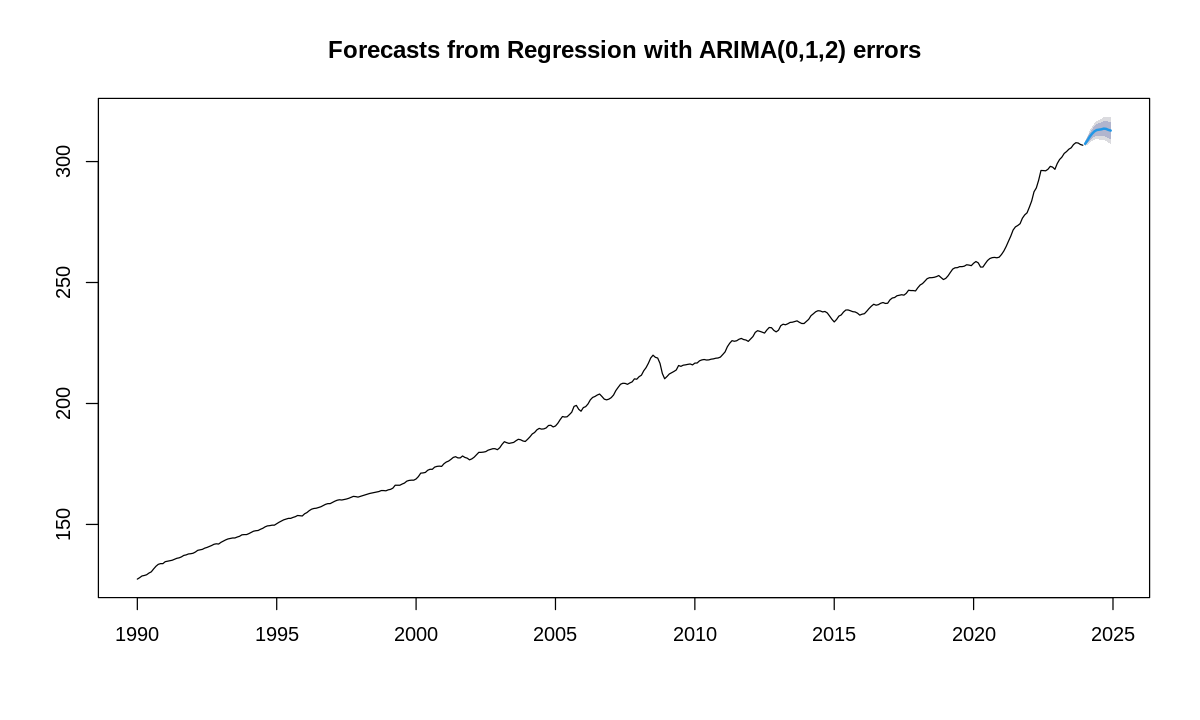

In [ ]:
# forecast the fitted model for h=12
best_harmonic.forecast <- forecast(best_harmonic, xreg=all_xreg_fcast, h=h)
plot(best_harmonic.forecast)

In [ ]:
# Get accuracy measures
accuracy(best_harmonic.forecast, ts_test[,"CPI"])

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.0006366855,0.5268475,0.3828308,-0.001199444,0.1865925,0.07119218,0.00184407,NA
Test set,1.7769816892,1.8445278,1.7769817,0.565946294,0.5659463,0.33045205,0.49823458,1.964446


Zoom in on the fitted and actual (forecast time period)

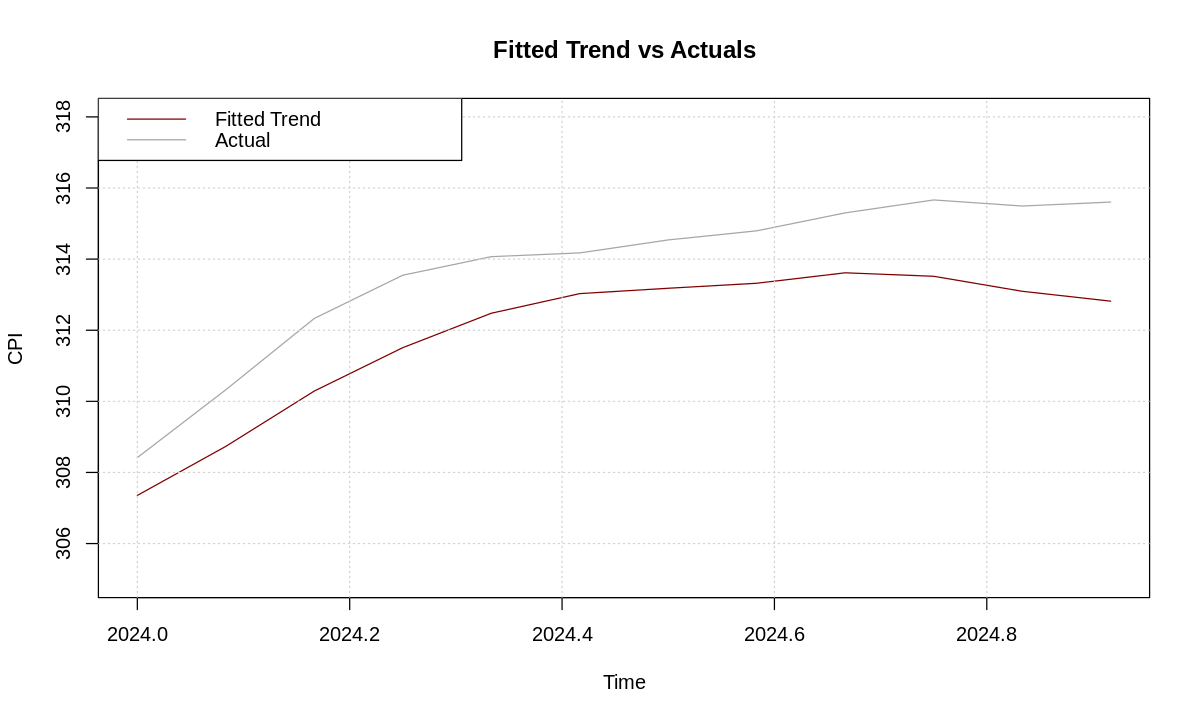

In [ ]:
# Set general labels and colors
model_labels <- c("Fitted Trend", "Actual")
model_colors <- c("#800000", "#A6A6A6")

# Plot the fitted trend
plot(best_harmonic.forecast$mean, ylim=c(305,318),
      ylab="CPI", xlab="Time",
      main="Fitted Trend vs Actuals", col=model_colors[1])

# Plot the actual
lines(ts_test[,"CPI"], col=model_colors[2])

# Add the grid
grid(nx = NULL, ny = NULL, col = "lightgray", lty = "dotted")

# Add the legend
legend("topleft", legend=model_labels,
     col=model_colors, lty=c(1,1))

View the fitted and actual (full time period)

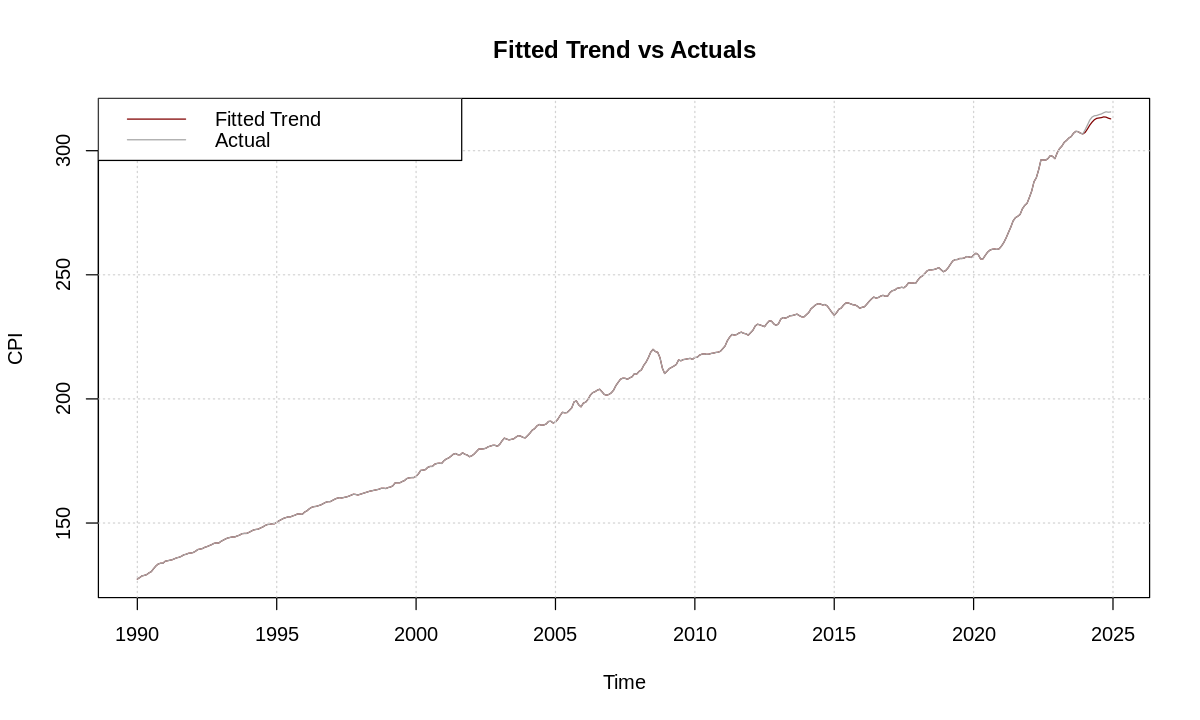

In [ ]:
# Set general labels and colors
model_labels <- c("Fitted Trend", "Actual")
model_colors <- c("#800000", "#A6A6A6")

# Plot the fitted trend
plot(ts(c(best_harmonic.forecast$x, best_harmonic.forecast$mean), start=c(1990,1), frequency=12),
      ylab="CPI", xlab="Time",
      main="Fitted Trend vs Actuals", col=model_colors[1])

# Plot the actual
lines(ts_data[,"CPI"], col=model_colors[2])

# Add the grid
grid(nx = NULL, ny = NULL, col = "lightgray", lty = "dotted")

# Add the legend
legend("topleft", legend=model_labels,
     col=model_colors, lty=c(1,1))

## Check residuals final model

Residuals do not fully resemble white noise. While no important lags with significant autocorrelation exist, there remain a handful of others that have significant autocorrelation.
Ljung-box test agrees with p-value < 0.05, indicating we should reject the null hypothesis that the residuals are independent.

However, based on the spectral analysis we have adequately specified the most significant lags that exhibit seasonal behaviour (6 and 12), and they no longer show significant correlation in the residuals.

While additional steps could be taken such as 1) higher K's in the harmonic specification or 2) specification of additional intervention events (a possible source of the spurrious correlations at odd lags), both options will invariably lead to a more complex model which we have decided not to further pursue in order to maintain parsimony.


	Ljung-Box test

data:  Residuals from Regression with ARIMA(0,1,2) errors
Q* = 38.62, df = 22, p-value = 0.01559

Model df: 2.   Total lags used: 24



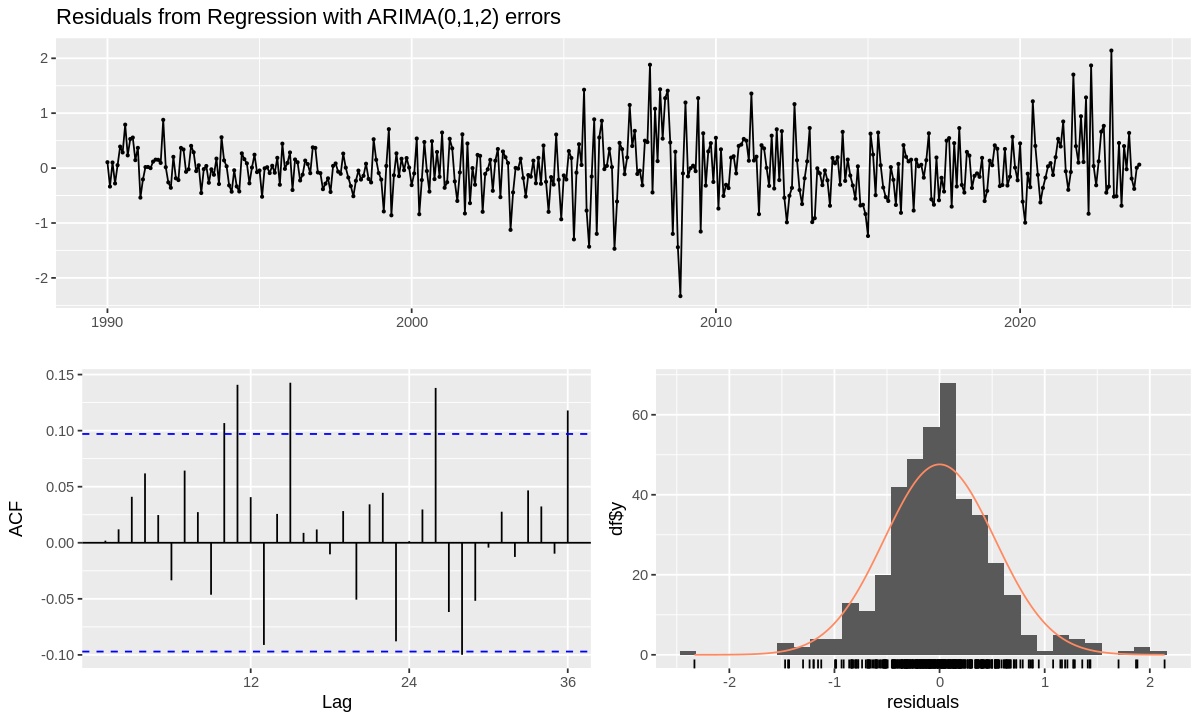

In [ ]:
# Check residuals
checkresiduals(best_harmonic)

# Additional rounds

## Model 1: Harmonic and Intervention Only
Since exogenous variables need also be forecasted, we fit one without to observe what the independent performance with only these two deterministic components

In [ ]:
# Only intervention and harmonic
step_intervention <- c(rep(0, t1), rep(1, t2-t1), rep(0, n-t2))
harmonics_3 <- ts_train[,"CPI"] %>% fourier(K=3)
all_xreg <- cbind(step_intervention, harmonics_3)

In [ ]:
best_harmonic_ex <- auto.arima(ts_train[,"CPI"], xreg=all_xreg, seasonal=FALSE)
best_harmonic_ex %>% summary()

Series: ts_train[, "CPI"] 
Regression with ARIMA(1,1,0) errors 

Coefficients:
         ar1   drift  step_intervention    S1-12    C1-12    S2-12    C2-12
      0.4923  0.4395            -2.1242  -0.1790  -0.7734  -0.1621  -0.2506
s.e.  0.0434  0.0544             0.3600   0.1209   0.1211   0.0453   0.0452
       S3-12    C3-12
      0.0081  -0.1380
s.e.  0.0249   0.0249

sigma^2 = 0.3188:  log likelihood = -340.44
AIC=700.88   AICc=701.44   BIC=740.97

Training set error measures:
                     ME      RMSE       MAE          MPE      MAPE       MASE
Training set 0.00102339 0.5576771 0.4028321 -0.005718059 0.1949122 0.07491168
                    ACF1
Training set 0.009968121


	Ljung-Box test

data:  Residuals from Regression with ARIMA(1,1,0) errors
Q* = 46.329, df = 23, p-value = 0.002722

Model df: 1.   Total lags used: 24



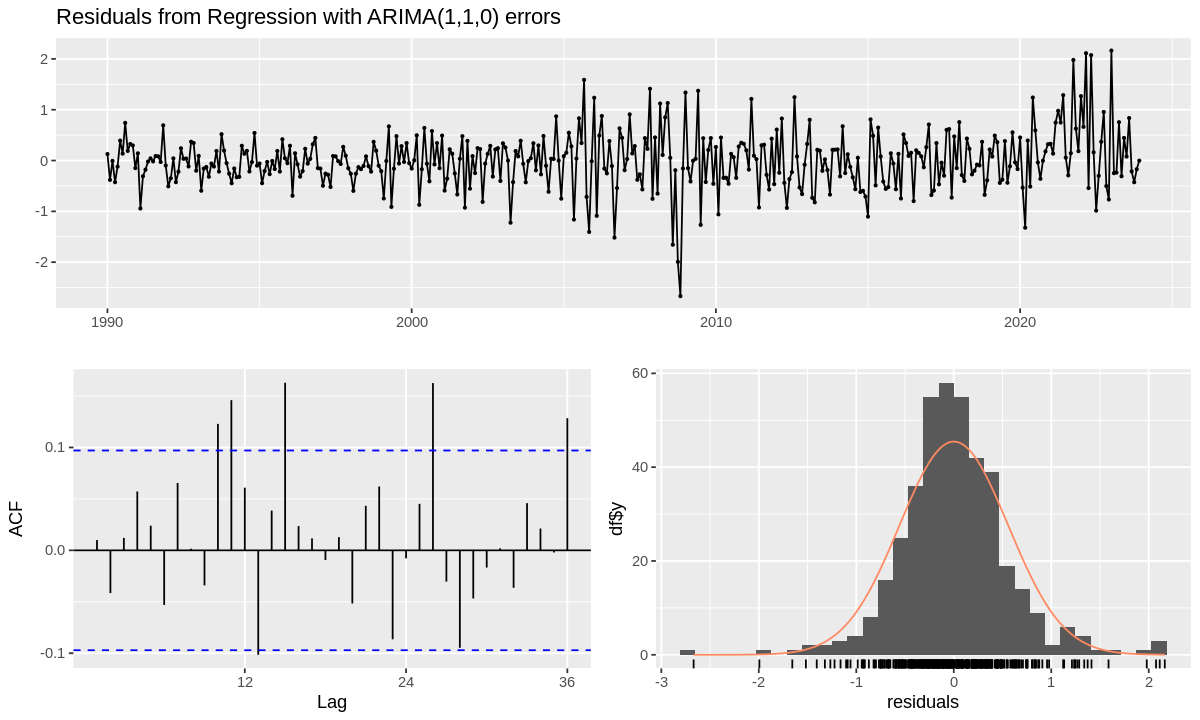

In [ ]:
# Check residuals
checkresiduals(best_harmonic_ex)

Warning message in forecast.forecast_ARIMA(best_harmonic_ex, xreg = all_xreg_fcast, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”


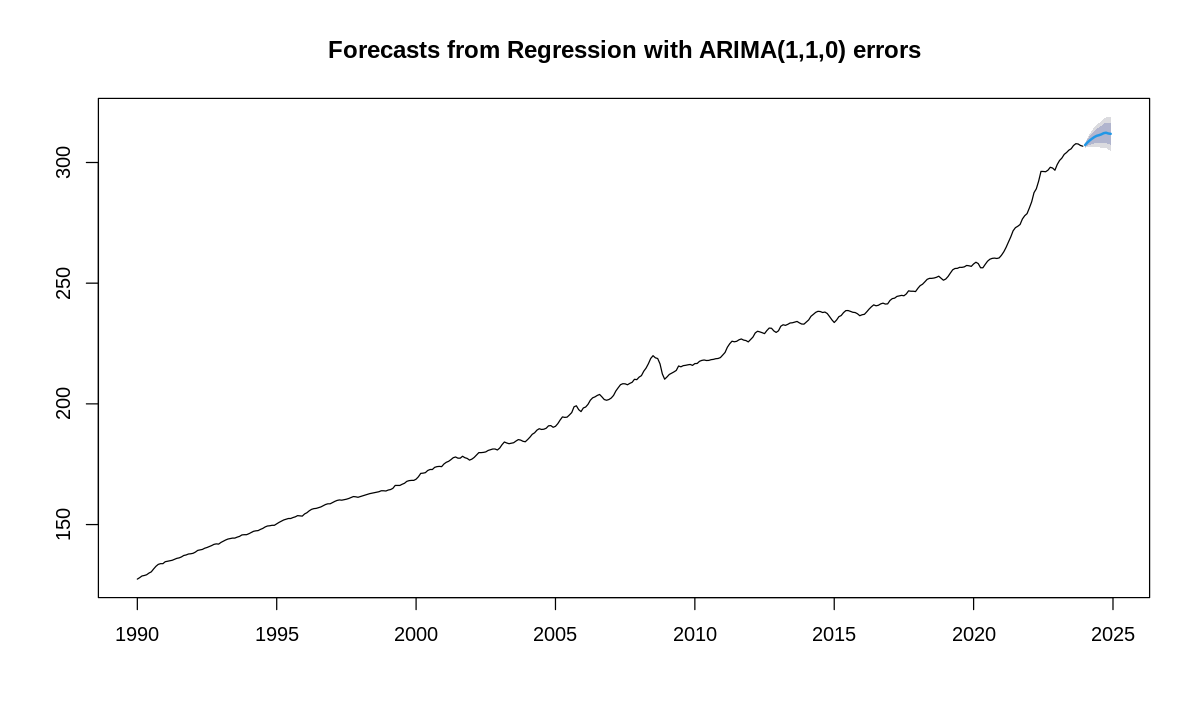

In [ ]:
# define the horizon to forecast
h <- 12

# define variables for forecast/testing data
step_intervention_fcst <- c(rep(0, h))
harmonics_3_fcst <- ts_train[,"CPI"] %>% fourier(K=3, h=h)

# combine to final matrix to feed into xreg for forecast
all_xreg_fcast <- cbind(
  step_intervention_fcst,
  harmonics_3_fcst)

# forecast the fitted model for h=12
best_harmonic_ex.forecast <- forecast(best_harmonic_ex, xreg=all_xreg_fcast, h=h)
plot(best_harmonic_ex.forecast)

In [ ]:
# Get accuracy measures
accuracy(best_harmonic_ex.forecast, ts_test[,"CPI"])

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.00102339,0.5576771,0.4028321,-0.005718059,0.1949122,0.07491168,0.009968121,NA
Test set,3.06277250,3.1420453,3.0627725,0.975028823,0.9750288,0.56956099,0.435723131,3.373938


## Model 2: Baseline

In [ ]:
baseline <- auto.arima(ts_train[,"CPI"], seasonal=TRUE)
baseline %>% summary()

Series: ts_train[, "CPI"] 
ARIMA(0,2,3)(0,0,2)[12] 

Coefficients:
          ma1      ma2      ma3    sma1    sma2
      -0.3859  -0.4551  -0.1355  0.1805  0.1338
s.e.   0.0498   0.0500   0.0532  0.0534  0.0483

sigma^2 = 0.3929:  log likelihood = -385.49
AIC=782.99   AICc=783.2   BIC=807.03

Training set error measures:
                     ME      RMSE       MAE         MPE      MAPE       MASE
Training set 0.01717916 0.6214364 0.4375386 0.003690955 0.2069341 0.08136579
                     ACF1
Training set -0.001590032

In [ ]:
# define the horizon to forecast
h <- 12
baseline.forecast <- forecast(baseline, h=h)

In [ ]:
# Get accuracy measures
accuracy(baseline.forecast, ts_test[,"CPI"])

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.01717916,0.6214364,0.4375386,0.003690955,0.2069341,0.08136579,-0.001590032,NA
Test set,1.43715668,1.7073338,1.4371567,0.458647739,0.4586477,0.26725732,0.714958667,1.837335


# Results Comparison

In [ ]:
# Accuracy metrics
baseline_acc <- accuracy(baseline.forecast, ts_test[,"CPI"])
harmonic_acc <- accuracy(best_harmonic_ex.forecast, ts_test[,"CPI"])
harmonic_exog_acc <- accuracy(best_harmonic.forecast, ts_test[,"CPI"])

# AICc and BIC
baseline_fit <- c(baseline.forecast$model$aicc, baseline.forecast$model$bic)
harmonic_fit <- c(best_harmonic_ex.forecast$model$aicc, best_harmonic_ex.forecast$model$bic)
harmonic_exog_fit <- c(best_harmonic.forecast$model$aicc, best_harmonic.forecast$model$bic)
fits <- rbind(baseline_fit, harmonic_fit, harmonic_exog_fit)

In [ ]:
colnames(fits) <- c("AICc","BIC")
fits

,AICc,BIC
baseline_fit,783.1992,807.0267
harmonic_fit,701.4395,740.9721
harmonic_exog_fit,663.6006,718.6525


In [ ]:
# Combine into table for train / table for test
train_acc <- cbind(fits, rbind(baseline_acc[1,], harmonic_acc[1,], harmonic_exog_acc[1,])) %>% round(3)
test_acc <- cbind(fits, rbind(baseline_acc[2,], harmonic_acc[2,], harmonic_exog_acc[2,])) %>% round(3)

In [ ]:
# Add AICc and BIC to both tables

In [ ]:
train_acc

,AICc,BIC,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
baseline_fit,783.199,807.027,0.017,0.621,0.438,0.004,0.207,0.081,-0.002,NA
harmonic_fit,701.440,740.972,0.001,0.558,0.403,-0.006,0.195,0.075,0.010,NA
harmonic_exog_fit,663.601,718.653,0.001,0.527,0.383,-0.001,0.187,0.071,0.002,NA


In [ ]:
test_acc

,AICc,BIC,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
baseline_fit,783.199,807.027,1.437,1.707,1.437,0.459,0.459,0.267,0.715,1.837
harmonic_fit,701.440,740.972,3.063,3.142,3.063,0.975,0.975,0.570,0.436,3.374
harmonic_exog_fit,663.601,718.653,1.777,1.845,1.777,0.566,0.566,0.330,0.498,1.964
